In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mglearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 2.3.5 决策树
决策树是广泛用于分类和回归任务的模型。本质上，它从一层层的if/else问题中进行学习，并得出结论。

比如下面的例子，树的每个结点代表一个问题或一个包含答案的终结点（也叫叶结点）。树的边将问题的答案与将问的下一个问题连接起来。用机器学习的语言来说就是，为了区分四类动物（鹰、企鹅、海豚和熊），我们利用三个特征（“有没有羽毛”“会不会飞”和“有没有鳍”）来构建一个模型。我们可以利用监督学习从数据中学习模型，而无需人为构建模型。

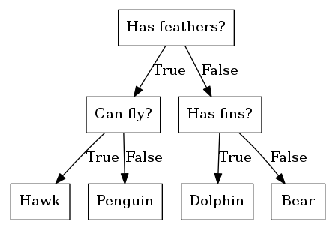

In [2]:
mglearn.plots.plot_animal_tree()
plt.show()

#### 2.3.5.1 构造决策树
`图2-23`显示的数据集由2个半月形组成，每个类别都包含50个数据点。我们将这个数据集称为two_moons。
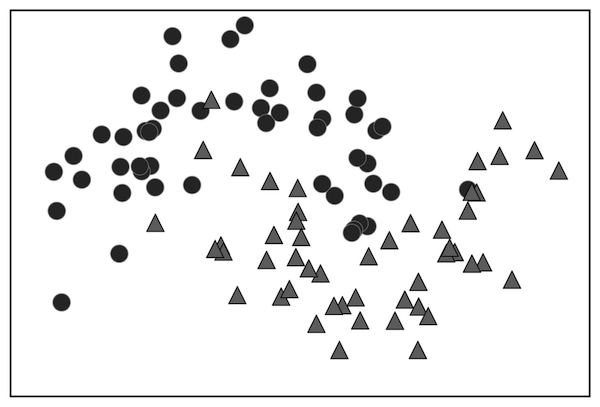
*图2-23：用于构造决策树的two_moons数据集*

为了构造决策树，算法搜遍所有可能的测试，找出对目标变量来说信息量最大的那一个。`图2-24`展示了选出的第一个测试。将数据集在$x[1]=0.0596$处垂直划分可以得到最多信息，它在最大程度上将类别0中的点与类别1中的点进行区分。根结点表示整个数据集，包含属于类别0的50个点和属于类别1的50个点。通过测试$x[1] <= 0.0596$的真假来对数据集进行划分，在图中表示为一条黑线。如果测试结果为真，那么将这个点分配给左结点，左结点里包含属于类别0的2个点和属于类别1的32个点。否则将这个点分配给右结点，右结点里包含属于类别0的48个点和属于类别1的18个点。这两个结点对应于图 2-24 中的顶部区域和底部区域。
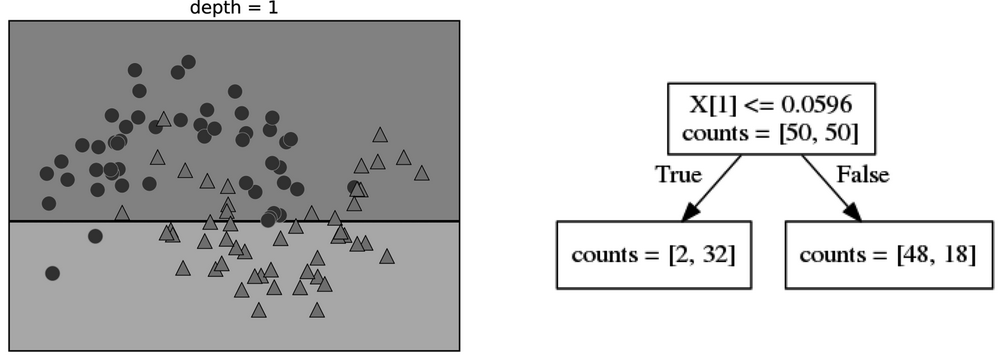
*图2-24：深度为1的树的决策边界(左)与相应的树(右)*

第一次划分之后，底部区域仍包含属于类别0的点，顶部区域也仍包含属于类别1的点。我们可以在两个区域中重复寻找最佳测试的过程，从而构建出更准确的模型。`图2-25`展示了信息量最大的下一次划分，这次划分是基于$x[0]$做出的，分为左右两个区域。
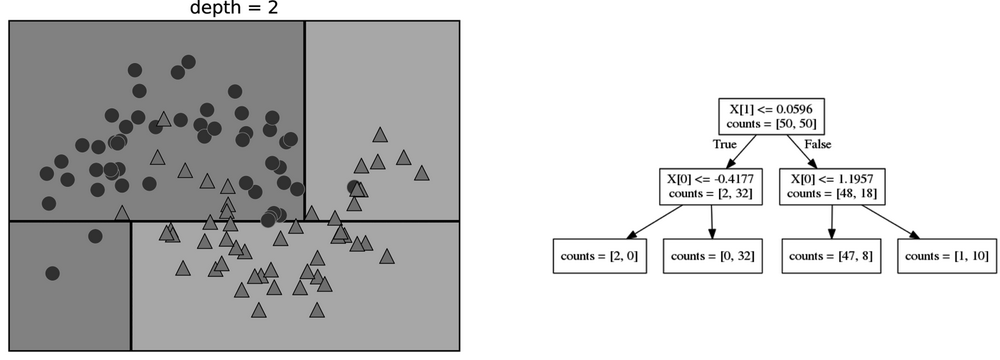
*图2-25：深度为2的树的决策边界(左)与相应的树(右)*

这一递归过程生成一棵二元决策树，其中每个结点都包含一个测试。或者你可以将每个测试看成沿着一条轴对当前数据进行划分。这是一种将算法看作分层划分的观点。由于每个测试仅关注一个特征，所以划分后的区域边界始终与坐标轴平行。

对数据反复进行递归划分，直到划分后的每个区域（决策树的每个叶结点）只包含单一目标值（单一类别或单一回归值）。如果树中某个叶结点所包含数据点的目标值都相同，那么这个叶结点就是纯的（pure）。这个数据集的最终划分结果见`图2-26`。
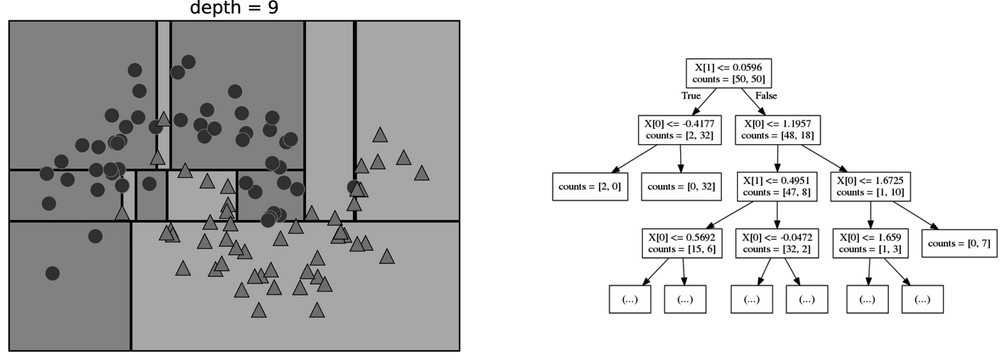
*图2-26：深度为9的树的决策边界(左)与相应的树的一部分(右)*

对新数据点进行预测，首先要查看这个点位于特征空间划分的哪个区域，然后将该区域的多数目标值作为预测结果。从根结点开始对树进行遍历就可以找到这一区域，每一步向左还是向右取决于是否满足相应的测试。

决策树也可以用于回归任务。预测的方法是，基于每个结点的测试对树进行遍历，最终找到新数据点所属的叶结点。这一数据点的输出即为此叶结点中所有训练点的平均目标值。

#### 2.3.5.2 控制决策树的复杂度
通常来说，构造决策树直到所有叶结点都是纯的叶结点，这会导致模型非常复杂，并且对训练数据高度过拟合。纯叶结点的存在说明这棵树在训练集上的精度是$100%$。在`图2-26`的左图中可以看出过拟合：在所有属于类别0的点中间有一块属于类别1的区域。另一方面，有一小条属于类别0的区域，包围着最右侧属于类别0的那个点。这这个决策边界过于关注远离同类别其他点的单个异常点。

防止过拟合有两种常见的策略：一种是及早停止树的生长，也叫预剪枝(pre-pruning)；另一种是先构造树，但随后删除或折叠信息量很少的结点，也叫后剪枝(post-pruning)或剪枝(pruning)。预剪枝的限制条件可能包括限制树的最大深度、限制叶结点的最大数目，或者规定一个结点中数据点的最小数目来防止继续划分。

**scikit-learn 的决策树在DecisionTreeRegressor类和DecisionTreeClassifier类中实现。scikit-learn只实现了预剪枝，没有实现后剪枝。**

我们在乳腺癌数据集上更详细地看一下预剪枝的效果。和前面一样，我们导入数据集并将其分为训练集和测试集。然后利用默认设置来构建模型，默认将树完全展开（树不断分支，直到所有叶结点都是纯的）。我们固定树的$random\_state$，用于在内部解决平局问题：

In [3]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


我们没有限制树的深度，每个记录都完美的分类了，训练集上的精度是$100%$。测试集精度比之前讲过的线性模型略低，线性模型的精度约为$95%$。如果我们不限制决策树的深度，它的深度和复杂度都可以变得特别大，模型容易过拟合而泛化性能不佳。

我们将预剪枝应用在决策树上，这可以在完美拟合训练数据之前阻止树的展开。一种选择是在到达一定深度后停止树的展开。这里我们设置$max\_depth=4$，这会降低训练集的精度，但可以提高测试集的精度：

In [4]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


#### 2.3.5.3 分析决策树
我们可以利用`tree模块`的`export_graphviz函数`来将树可视化：

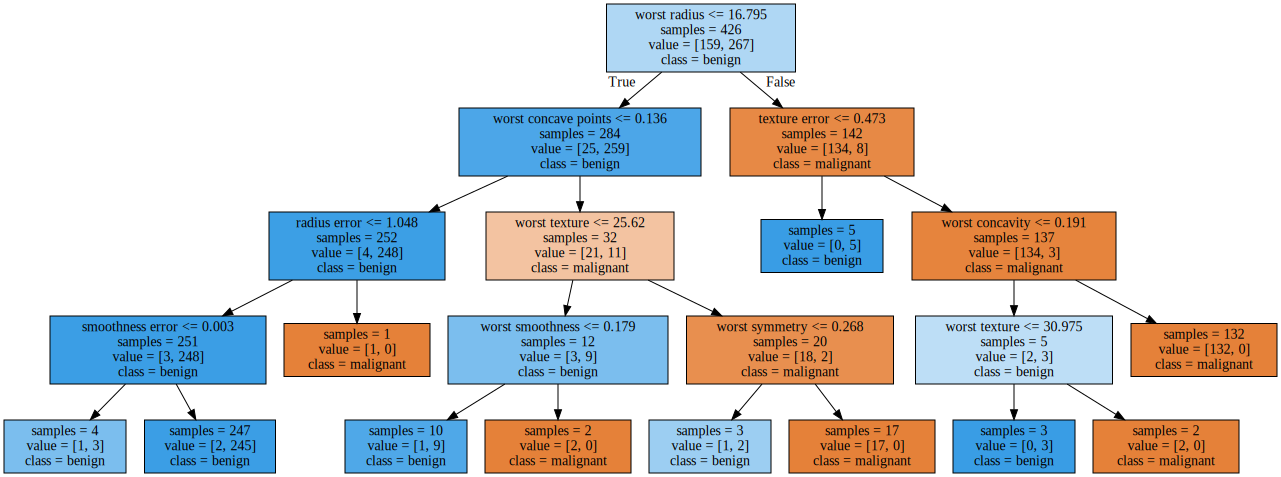

In [5]:
# 注意：这两个语句不要放在开头，否则后面的代码会运行出错！！！
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"], 
                feature_names=cancer.feature_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### 2.3.5.4 树的特征重要性
查看整个树可能非常费劲，我们可以利用一些有用的属性来总结树的工作原理，其中最常用的是特征重要性(feature importance)，它为每个特征对树的决策的重要性进行排序。对于每个特征来说，它都是一个介于$0$和$1$之间的数字，其中$0$表示“根本没用到”，$1$表示“完美预测目标值”。特征重要性的求和始终为$1$：

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]
range(0, 30)


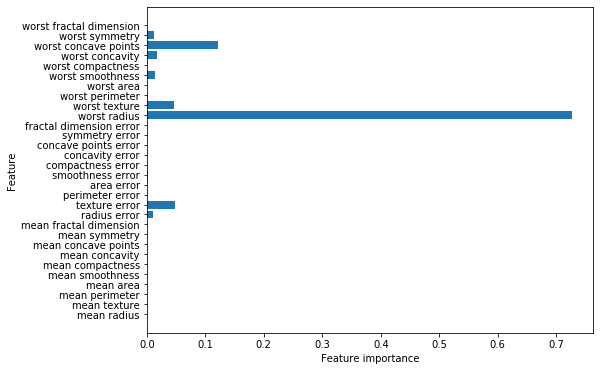

In [6]:
print("Feature importances:\n{}".format(tree.feature_importances_))

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1] 
    print(range(n_features))
    plt.barh(y = range(n_features), width = model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), cancer.feature_names) 
    plt.xlabel("Feature importance") 
    plt.ylabel("Feature")

plt.gcf().set_size_inches(8, 6)
plot_feature_importances_cancer(tree)
plt.show()

这里我们看到，顶部划分用到的特征(“worst radius”)是最重要的特征。这也证实了我们在分析树时的观察结论，即第一层划分已经将两个类别区分得很好。

但是，如果某个特征的$feature\_importance\_$很小，并不能说明这个特征没有提供任何信息。这只能说明该特征没有被树选中，可能是因为另一个特征也包含了同样的信息。

与线性模型的系数不同，特征重要性始终为正数，也不能说明该特征对应哪个类别。特征重要性告诉我们“worst radius”特征很重要，但并没有告诉我们半径大表示样本是良性还是恶性。事实上，在特征和类别之间可能没有这样简单的关系。下面的例子说明了这个特性：我们使用有两个特征和两个类别的数据集。这里所有信息都包含在$X[1]$中，没有用到$X[0]$。但$X[1]$和输出类别之间并不是单调关系，即我们不能这么说：“较大的$X[1]$对应类别$0$，较小的$X[1]$对应类别$1$”（反之亦然）：

Feature importances: [0. 1.]


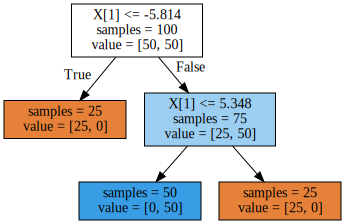

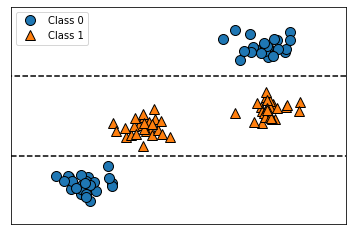

In [7]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)
plt.show()

上面我们主要讨论的是用于分类的决策树，但对用于回归的决策树来说，所有内容都是类似的，在DecisionTreeRegressor中实现。回归树的用法和分析与分类树非常类似。但在将基于树的模型用于回归时，我们想要指出它的一个特殊性质。DecisionTreeRegressor（以及其他所有基于树的回归模型）不能外推（extrapolate），也不能在训练数据范围之外进行预测。

我们利用计算机内存（RAM）历史价格的数据集来更详细地研究这一点。`图2-31`给出了这个数据集的图像，$x$轴为日期，$y$轴为那一年1MB RAM的价格：

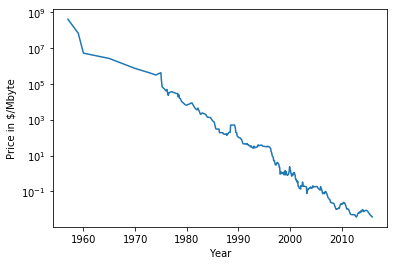

In [8]:
ram_prices = pd.read_csv("data/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.show()

注意$y$轴的对数刻度。在用对数坐标绘图时，二者的线性关系看起来非常好，所以预测应该相对比较容易，除了一些不平滑之处之外。

我们将利用$2000$年前的历史数据来预测$2000$年后的价格，只用日期作为特征。我们将对比两个简单的模型$DecisionTreeRegressor$和$LinearRegression$。我们对价格取对数，使得二者关系的线性相对更好。这对$DecisionTreeRegressor$不会产生什么影响，但对$LinearRegression$的影响却很大。训练模型并做出预测之后，我们应用指数映射来做对数变换的逆运算。为了便于可视化，我们这里对整个数据集进行预测，但如果是为了定量评估，我们将只考虑测试数据集：

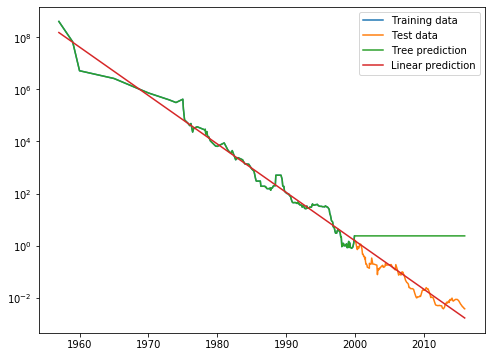

In [9]:
# 利用历史数据预测2000年后的价格
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 基于日期来预测价格
X_train = data_train.date[:, np.newaxis]
# 我们利用对数变换得到数据和目标之间更简单的关系
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 对所有数据进行预测
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 对数变换逆运算
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()
plt.gcf().set_size_inches(8, 6)
plt.show()

两个模型之间的差异非常明显。线性模型用一条直线对数据做近似，这是我们所知道的。这条线对测试数据(2000年后的价格)给出了相当好的预测，不过忽略了训练数据和测试数据中一些更细微的变化。与之相反，树模型完美预测了训练数据。由于我们没有限制树的复杂度，因此它记住了整个数据集。但是，一旦输入超出了模型训练数据的范围，模型就只能持续预测最后一个已知数据点。树不能在训练数据的范围之外生成“新的”响应。所有基于树的模型都有这个缺点。

#### 2.3.5.5 优点、缺点和参数
如前所述，控制决策树模型复杂度的参数是预剪枝参数，它在树完全展开之前停止树的构造。通常来说，选择一种预剪枝策略(设置$max\_depth$、$max\_leaf\_nodes$或$min\_samples\_leaf$)足以防止过拟合。

与前面讨论过的许多算法相比，决策树有两个优点：一是得到的模型很容易可视化，非专家也很容易理解；二是算法完全不受数据缩放的影响。由于每个特征被单独处理，而且数据的划分也不依赖于缩放，因此决策树算法不需要特征预处理，比如归一化或标准化。特别是特征的尺度完全不一样时或者二元特征和连续特征同时存在时，决策树的效果很好。

决策树的主要缺点在于，即使做了预剪枝，它也经常会过拟合，泛化性能很差。因此，在大多数应用中，往往使用下面介绍的集成方法来替代单棵决策树。